## ПАРАМЕТРЫ

In [1]:
# Порог (threshold): показания датчиков ниже порогового заменяются 0 значением
tres = 250

# Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = np.load ( 'X_train.npy')
X_train.shape

(165, 40, 60)

In [4]:
X_test = np.load ( 'X_test.npy')
X_test.shape

(166, 40, 60)

# Предобработка данных

In [5]:
# Показания датчиков ниже порогового заменяются 0 значением
# для тренировочной выборки

X_tres_train = np.copy(X_train)

for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            if X_train[i][j][k] <= tres:
                X_tres_train[i][j][k] = 0
            else:
                X_tres_train[i][j][k] = X_train[i][j][k]
            

In [6]:
# Показания датчиков ниже порогового заменяются 0 значением
# для тестовой выборки

X_tres_test = np.copy(X_test)

for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            if X_test[i][j][k] <= tres:
                X_tres_test[i][j][k] = 0
            else:
                X_tres_test[i][j][k] = X_test[i][j][k]
                
            

In [7]:
# Нормализация данных по строкам: делим все значения в одной строке 
# на максимальное значение в этой строке

def row_normalization(dataset):
    for observation in dataset:
        sensors_maxs = [sensor.max() for sensor in observation]
        for index, sensor in enumerate(observation):
            if sensors_maxs[index] > 0:
                observation[index] = sensor / sensors_maxs[index]
            else:
                observation[index] = 0

    return dataset

In [8]:
# Нормализуем тренировоную и тестовую выборки

x_tr = np.copy(X_tres_train)
x_tr = row_normalization(x_tr)
print(x_tr[:2])

x_test = np.copy(X_tres_test)
x_test = row_normalization(x_test)
print(x_test[:2])

[[[0.99700375 0.99850187 0.99700375 ... 0.62771536 0.63071161 0.63520599]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.99729416 0.99845381 0.99768071 ... 0.29648241 0.29377658 0.29454967]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.73671498 0.75120773 0.73429952 ... 0.82608696 0.81884058 0.81400966]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.7235387  0.72748815 0.72590837 ... 0.79541864 0.7906793  0.78672986]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.75637755 0.7557398  0.75510204 ... 0.97640306 0.97130102 0.97002551]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.93311037 0.92474916 0.9264214  ... 0.90635452 0.9180602  0.91471572]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[[[0.85058215 0.84799483 0.84734799 ... 0.98965071 0.9851229  0.98318241]
  [0.         0.      

# Conv1D Сверточная нейронная сеть

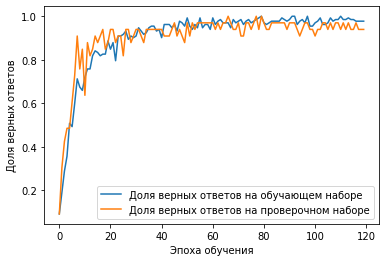

0.9772727489471436
0.939393937587738


In [9]:
# Загрузить библиотеки
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import backend as K
from sklearn.model_selection import train_test_split

# Задать начальное значение для ГПСЧ
np.random.seed(0)

height = 60     # временной интервал
width = 40      # кол-во датчиков

scaled_train = x_tr

y_train_csv = pd.read_csv('y_train.csv')
y = y_train_csv['Class'].values

test_size = 0.2
random_state = 153

# выделим % данных на тестовую выборку (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_train, y, test_size=test_size, random_state=random_state, stratify=y
)

# Преобразовать цель в кодировку с одним активным состоянием ohe
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
number_of_classes = y_test.shape[1]

# Инициализировать нейронную сеть
network = Sequential()

# Добавить сверточный слой с 192 фильтрами, ядро в одну строку и 
# активационной функций linear
network.add(Conv1D(filters=192,
                   kernel_size=1,
                   input_shape=(width, height),
                   activation='linear'))

# Добавить максимально редуцирующий слой с окном 2x2
network.add(MaxPooling1D(pool_size=2))

# Добавить отсеивающий слой
network.add(Dropout(0.5))

# Добавить слой для сглаживания входа
network.add(Flatten())

# Добавить полносвязный слой из 160 блоков с
# активационной функций linear
network.add(Dense(160, activation="linear"))

# Добавить отсеивающий слой
network.add(Dropout(0.5))

# Добавить полносвязный слой c
# активационной функцией softmax
network.add(Dense(number_of_classes, activation="softmax"))

# Скомплировать нейронную сеть
network.compile(
    loss="categorical_crossentropy", # Перекрестная энтропия
    optimizer="rmsprop",  # Распространение СКО
    metrics=["accuracy"]) # Точностный показатель результативности

# Натренировать нейронную сеть
history = network.fit(
    X_train,  # Признаки
    y_train,    # Цель
    epochs=120,        # Количество эпох
    verbose=0,       # Не печатать описание после каждой эпохи
    batch_size=15, # Количество наблюдений на пакет
    validation_data=(X_test, y_test)) # Данные для оценивания

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

print(history.history['accuracy'][-1])
print(history.history['val_accuracy'][-1])

# Подготовка submission

In [10]:
# network.save('model-192-1-160-lin.h5')

In [11]:
y_test = network.predict(x_test)
y_csv = [y.argmax() for y in y_test] # из ohe в числа
print(y_csv)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['Class'] = np.array(y_csv)
sample_submission.to_csv(f'submission_4_2022.csv', index=False)

6/6 [==============================] - 0s 2ms/step
[10, 1, 10, 13, 4, 5, 15, 6, 3, 13, 2, 3, 5, 8, 12, 7, 0, 11, 12, 0, 12, 14, 4, 10, 0, 10, 15, 5, 6, 4, 15, 1, 2, 15, 12, 12, 9, 8, 14, 2, 12, 3, 8, 14, 3, 8, 13, 13, 7, 10, 4, 3, 1, 13, 11, 13, 12, 0, 6, 2, 1, 6, 11, 3, 6, 3, 5, 11, 13, 5, 14, 2, 7, 15, 15, 4, 2, 6, 0, 7, 12, 5, 9, 11, 1, 5, 15, 9, 8, 14, 14, 1, 2, 11, 9, 1, 5, 14, 3, 9, 5, 2, 10, 15, 9, 7, 10, 10, 4, 9, 6, 14, 6, 12, 0, 11, 2, 8, 3, 11, 13, 7, 10, 10, 11, 5, 6, 0, 9, 10, 12, 8, 0, 8, 7, 3, 12, 4, 9, 15, 2, 4, 4, 7, 6, 6, 1, 9, 3, 11, 13, 8, 12, 0, 7, 2, 1, 0, 15, 0, 9, 14, 13, 3, 9, 6]
